In [2]:
import numpy as np # untuk mengolah dataset
import pandas as pd # untuk data processing, import dan olahnya
import seaborn as sns # untuk visualisasi outlier nanti
import matplotlib.pyplot as plt # untuk visualisasi outlier nanti
import missingno as msno # untuk visualisasi missing value nanti

#import data yang telah di merge dari kaggle
train = pd.read_csv("C:/Users/arela/Downloads/mycsvfile.csv")
train.head(5)

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 00:00:00,0.0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,0,Education,7432,2008.0,NaN,0,2016-01-01 01:00:00,0.0,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,0,Education,7432,2008.0,NaN,0,2016-01-01 02:00:00,0.0,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,0,Education,7432,2008.0,NaN,0,2016-01-01 03:00:00,0.0,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,0,Education,7432,2008.0,NaN,0,2016-01-01 04:00:00,0.0,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


**Preprocessing**

Tujuan atau Permasalahan utama dari kasus ini sebenarnya adalah forecasting/peramalan penggunaan energy.

Pertama-tama, cek informasi apa saja yang ada di tabel

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   site_id             int64  
 1   building_id         int64  
 2   primary_use         object 
 3   square_feet         int64  
 4   year_built          float64
 5   floor_count         float64
 6   meter               int64  
 7   timestamp           object 
 8   meter_reading       float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
dtypes: float64(10), int64(4), object(2)
memory usage: 2.4+ GB


Untuk data-data kategorik, akan dicek kategori apa saja yang ada didalamnya. Kemudian akan diubah tipe data tersebut yang sebelumnya integer atau float menjadi category supaya memudahkan preprocessing

In [4]:
banyaknya_lokasi = train['site_id'].unique()
print('Daftar site_id \n',banyaknya_lokasi)
print('Banyaknya lokasi gedung: ',len(banyaknya_lokasi),'\n')

banyaknya_gedung = train['building_id'].unique()
print('Daftar building_id \n',banyaknya_gedung)
print('Banyaknya gedung: ',len(banyaknya_gedung),'\n')

peruntukan_gedung = train['primary_use'].unique()
print('Daftar peruntukan gedung: ',peruntukan_gedung)
print('Banyaknya kategori peruntukan gedung: ',len(peruntukan_gedung),'\n')

jenis_meter = train['meter'].unique()
print('Jenis meter yang digunakan: ',jenis_meter)
print('Banyaknya jenis meter yang digunakan: ',len(jenis_meter))

Daftar site_id 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Banyaknya lokasi gedung:  16 

Daftar building_id 
 [   0    1    2 ... 1446 1447 1448]
Banyaknya gedung:  1449 

Daftar peruntukan gedung:  ['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']
Banyaknya kategori peruntukan gedung:  16 

Jenis meter yang digunakan:  [0 1 3 2]
Banyaknya jenis meter yang digunakan:  4


In [5]:
train['site_id'] = train['site_id'].astype('category')
train['building_id'] = train['building_id'].astype('category')
train['primary_use'] = train['primary_use'].astype('category')
train['meter'] = train['meter'].astype('category')
train['timestamp'] = train['timestamp'].astype('category') #data timestamp akan dijadikan kategori karena bukanlah suatu ukutan
train['year_built'] = train['year_built'].astype('category') #tahun pembuatan akan dijadikan kategori karena bukanlah suatu ukuran

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype   
---  ------              -----   
 0   site_id             category
 1   building_id         category
 2   primary_use         category
 3   square_feet         int64   
 4   year_built          category
 5   floor_count         float64 
 6   meter               category
 7   timestamp           category
 8   meter_reading       float64 
 9   air_temperature     float64 
 10  cloud_coverage      float64 
 11  dew_temperature     float64 
 12  precip_depth_1_hr   float64 
 13  sea_level_pressure  float64 
 14  wind_direction      float64 
 15  wind_speed          float64 
dtypes: category(6), float64(9), int64(1)
memory usage: 1.7 GB


Sehingga didapatkan informasi pada tabel dari setiap kolom sebagai berikut :
1. site_id : ID lokasi gedung, terdapat 16 lokasi gedung
2. building_id : ID gedung, terdapat 1449 gedung
3. primary_use : Peruntukan gedung, terdapat 16 kategori
4. square_feet : Luas bangunan gedung
5. year_built : Tahun pembuatan gedung
6. floor_count : Banyaknya lantai yang ada di gedung
7. meter: Jenis meter reading penggunaan energi gedung. Terdapat 4 jenis yaitu ```0```: electricity, ```1```: chilledwater, ```2```: steam, ```3```:hotwater (dari data)
8. time_stamp : Waktu saat pengukuran (per jam)
9. meter_reading : Penggunaan energi
10. air_temperature : Suhu udara
11. cloud_coverage : Ukuran berawan / porsi langit yang tertutup awan 
12. dew_temperature : Suhu embun 
13. precip_depth_1_hr : Presipitasi (banyaknya air dari langit)
14. sea_level_pressure : Tekanan permukaan laut
15. wind_direction : Arah angin
16. wind_speed : Kecepatan angin

**Melihat Statistika Deskriptifnya**

In [7]:
#Akan dicek statistika deskriptifnya
train.describe(include="all") #untuk melihat semua kolom

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,20216100.0,20216100.0,20216100,2.021610e+07,8088455.0,3.506933e+06,20216100.0,20216100,2.021610e+07,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
unique,16.0,1449.0,16,NaN,116.0,NaN,4.0,8784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,13.0,1249.0,Education,NaN,1976.0,NaN,0.0,2016-12-27 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2711763.0,35136.0,8165504,NaN,531091.0,NaN,12060910.0,2370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.077830e+05,NaN,4.184848e+00,NaN,NaN,2.117121e+03,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00
std,NaN,NaN,NaN,1.171424e+05,NaN,4.008277e+00,NaN,NaN,1.532356e+05,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00
min,NaN,NaN,NaN,2.830000e+02,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,3.252700e+04,NaN,1.000000e+00,NaN,NaN,1.830000e+01,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,NaN,NaN,NaN,7.270900e+04,NaN,3.000000e+00,NaN,NaN,7.877500e+01,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,NaN,NaN,NaN,1.391130e+05,NaN,6.000000e+00,NaN,NaN,2.679840e+02,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00


Didapatkan beberapa insight data dari statistika deskriptif ini, misalnya mean, jumlah, nilai maksimum dan minimum, quartil dan standar deviasi datanya.


Perhatikan kolom precip_depth_1_hr, nilai terkecilnya adalah **-1,00**. Padahal presipitasi adalah ukuran tetes air hujan sehingga tidak seharusnya bernilai negatif. Maka terdapat indikasi adanya kesalahan data pada variabel ini. Selanjutnya akan dilihat berapa banyak data precip_depth_1_hr yang bernilai negatif.

In [8]:
#Data precip yang bernilai negatif atau kurang dari 0
jumlahsalah_precip = train[train['precip_depth_1_hr']<0]['precip_depth_1_hr'].count()
print('Jumlah data presipitasi yang bernilai negatif : ',jumlahsalah_precip)
#Presentase yang bernilai negatif
persentasesalah_precip = ((train[train['precip_depth_1_hr']<0]['precip_depth_1_hr'].count())/(train['precip_depth_1_hr'].count()))*100
print('Persentase data presipitasi yang kemungkinan salah: ',persentasesalah_precip,'%')
#Cek apakah nilai data yang negatif sama semua
salah_precip = train[train['precip_depth_1_hr']==-1]['precip_depth_1_hr'].count()
print('Jumlah data presipitasi yang bernilai -1.00 : ',salah_precip)

Jumlah data presipitasi yang bernilai negatif :  1093352
Persentase data presipitasi yang kemungkinan salah:  6.639624020705071 %
Jumlah data presipitasi yang bernilai -1.00 :  1093352


Dapat dilihat persentase data tersebut yang kemungkinan salah ada sekitar 6.63%. Dan ternyata data yang salah tersebut semuanya bernilai -1.00. Oleh karena itu, data yang bernilai -1.00 dapat dengan aman kita ganti menjadi 0.00 (dengan asumsi tidak terjadi presipitasi di daerah tersebut)

In [9]:
#mengganti data yang bernilai -1.00 menjadi 0
train['precip_depth_1_hr'].replace(-1.0,0.0, inplace=True) #inplace=true supaya mengupdate tabelnya dengan nilai terbaru
train.describe()

,square_feet,floor_count,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,3.506933e+06,2.021610e+07,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,1.077830e+05,4.184848e+00,2.117121e+03,1.598795e+01,1.900423e+00,7.747429e+00,8.628118e-01,1.016085e+03,1.730151e+02,3.377525e+00
std,1.171424e+05,4.008277e+00,1.532356e+05,1.094729e+01,2.402909e+00,1.017867e+01,7.457168e+00,7.060539e+00,1.140574e+02,2.265694e+00
min,2.830000e+02,1.000000e+00,0.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,0.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.252700e+04,1.000000e+00,1.830000e+01,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,7.270900e+04,3.000000e+00,7.877500e+01,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.391130e+05,6.000000e+00,2.679840e+02,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,8.750000e+05,2.600000e+01,2.190470e+07,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


**Mendeteksi Outlier**

Untuk mendeteksi outlier, akan digunakan visualisasi dengan menggunakan boxplot pada package seaborn untuk setiap variabel numerik

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


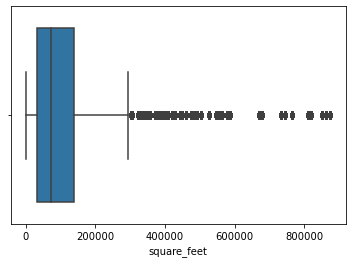

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


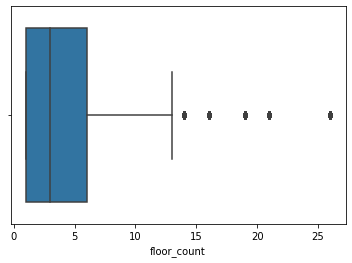

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


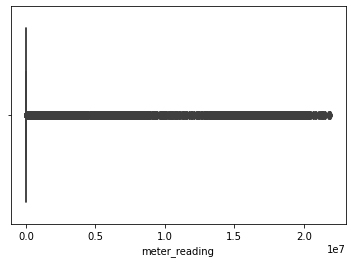

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


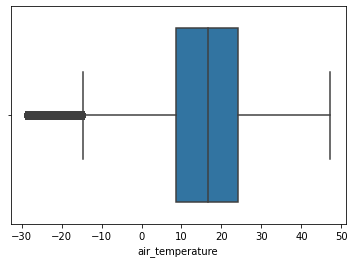

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


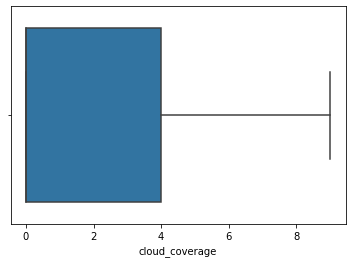

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


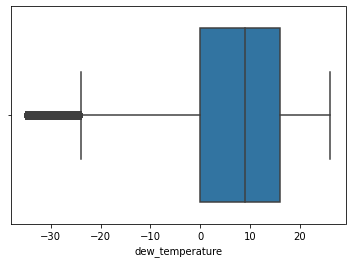

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


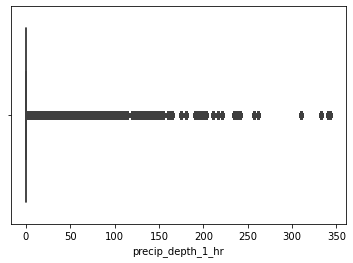

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


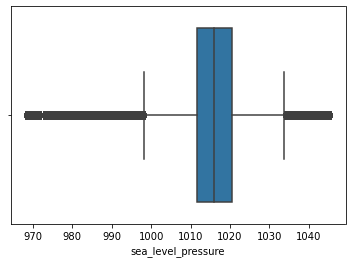

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


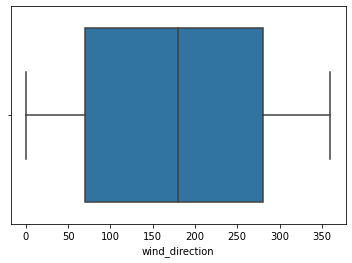

C:\Users\arela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


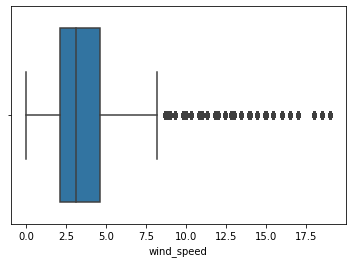

In [27]:
columns = train.columns.values
for i in columns:
    if train[i].dtype=='float64'or train[i].dtype=='int64':
       sns.boxplot(train[i])
       plt.show()

Dapat dilihat dari boxplot tersebut, banyak kolom atau variabel yang memiliki outlier, terutama square_feet (luas gedung), floor_count (banyaknya lantai di gedung), meter_reading (konsumsi energi), air_temperature (suhu udara), dew_temperature (suhu embun), precip_depth_1hr (presipitasi), sea_level_pressure (tekanan permukaan laut), dan wind_speed (kecepatan angin).
 
Meskipun persebaran outliernya cukup skewed namun outlier data tersebut tidak ada yang terlalu jauh dari yang lainnya. Data tersebut juga masih tergolong valid (tidak ada anomali). Oleh karena itu, outlier data tidak perlu dirubah/dibiarkan saja.

**Mencari Missing Values**

In [10]:
#Menghitung jumlah missing values pada masing-masing kolom / variabel
train.isnull().sum()

site_id                      0
building_id                  0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
meter                        0
timestamp                    0
meter_reading                0
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

In [11]:
# Persentase missing values
(train.isnull().sum()/len(train)*100).to_frame('persentase missing')

,persentase missing
site_id,0.000000
building_id,0.000000
primary_use,0.000000
square_feet,0.000000
year_built,59.990033
floor_count,82.652772
meter,0.000000
timestamp,0.000000
meter_reading,0.000000
air_temperature,0.478124


Dapat dilihat, banyak kolom atau variabel yang memiliki missing values, seperti year_built, floor_count, air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_direction, dan wind_speed.

<AxesSubplot:>

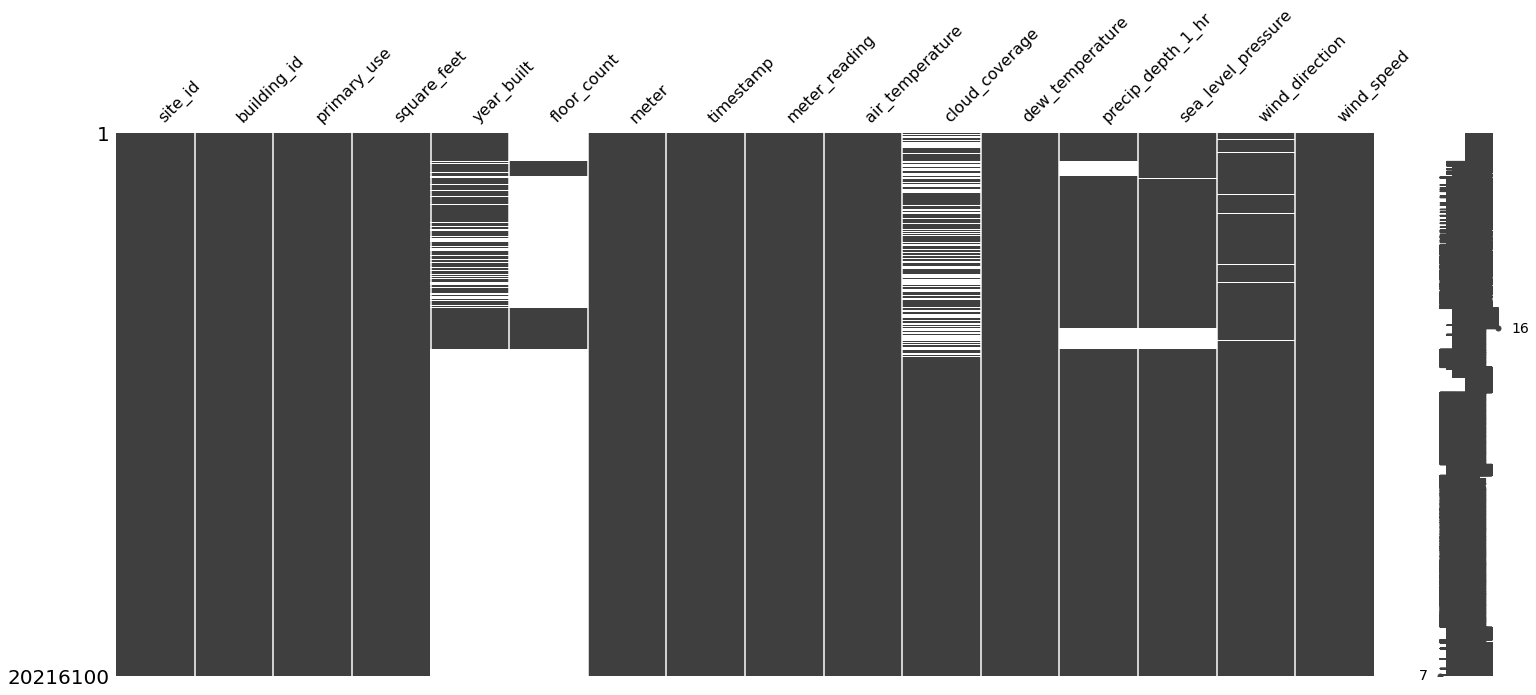

In [15]:
# Visualisasi missing values
# Matrix Plot
msno.matrix(train)

<AxesSubplot:>

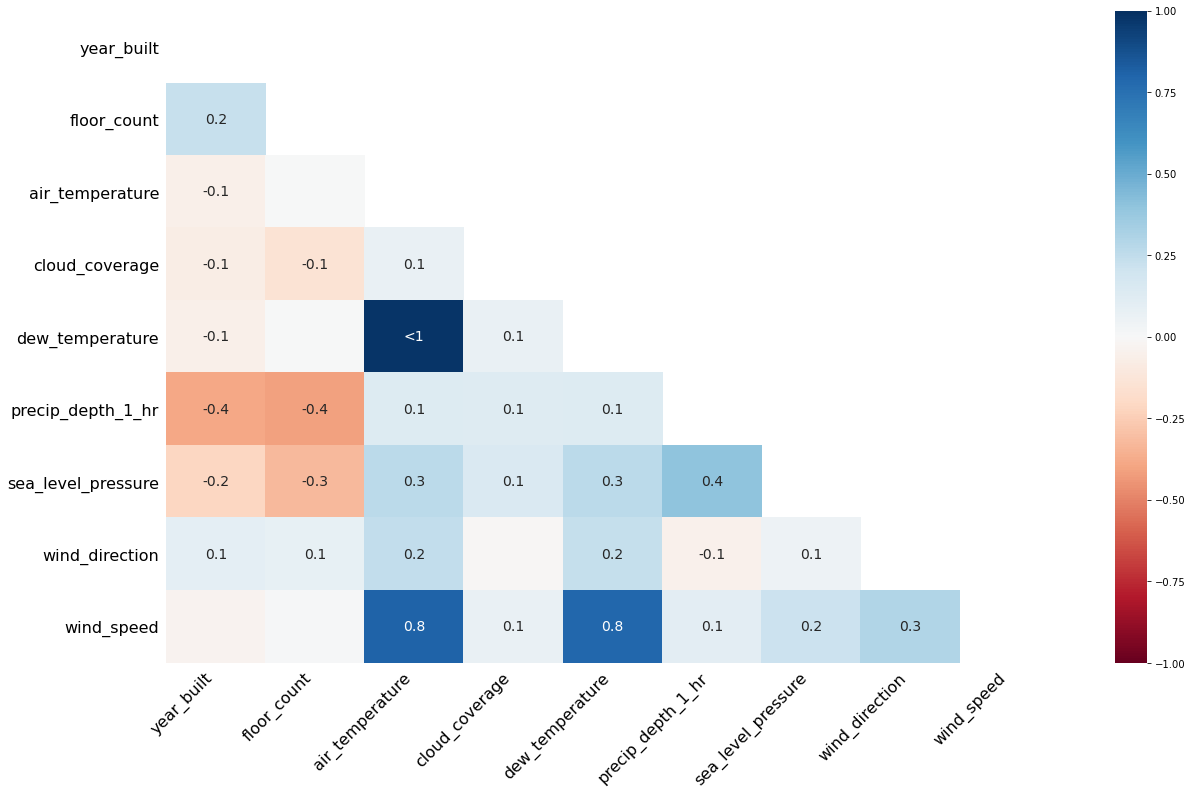

In [16]:
# Heatmap
msno.heatmap(train)

Penjelasan Visualisasi :

- Plot matriks memberikan isian warna untuk setiap kolom. Jika datanya ada, plot diarsir akan dalam warna abu-abu, namun jika tidak ada, plot ditampilkan dalam warna putih.

- Heatmap digunakan untuk mengidentifikasi korelasi missing value antara masing-masing kolom yang berbeda. Dengan kata lain, ini dapat digunakan untuk mengidentifikasi apakah ada hubungan dengan adanya missing value di antara masing-masing kolom. Nilai yang mendekati positif 1 menunjukkan bahwa keberadaan missing value di satu kolom berkorelasi dengan keberadaan missing value di kolom lain. Dan berlaku kebalikannya jika mendekati negatif 1. Nilai yang mendekati 0, menunjukkan ada sedikit atau tidak ada hubungan antara keberadaan nilai nol dalam satu kolom dibandingkan dengan kolom lainnya.

Berdasarkan data visualisasi tersebut, missing value tidak terlalu bergantung antara variabel/kolom satu dengan yang lain (pengecualian pada variabel air_temperature dan dew_temperature). Sehingga ini termasuk dalam kasus MCAR (Missing Completly At Random). 

Perlu diperhatikan bahwa terdapat missing values pada semua data mulai dari pertengahan kebawah di variabel year_built dan floor_count (persentase missing value lebih besar dari 50%). Karena data tidak terlalu esensial, sebaiknya kedua data ini dihapuskan.

Sisanya, dilihat dari presentase missing valuenya, rata-rata berada di bawah 18%. (Pengecualian pada variabel cloud_coverage). Kemudian, tidak ada data kategorik yang mempunyai missing value. Sehingga, karena datanya juga tersebar dengan luas / cukup skewed (lihat boxplot saat mendeteksi outlier), akan lebih baik menggunakan cara imputasi dengan median untuk mengatasi missing value tersebut, karena median tidak terinfluensikan oleh nilai yang besar. 

Untuk baris yang mempunyai lebih dari 2 missing value, akan lebih aman untuk di delete saja.

In [12]:
# menghapus/mendrop kolom year_built dan floor_count karena mempunyai missing value yang lebih besar dari 50%
train.drop(labels=['year_built','floor_count'], axis=1, inplace=True)
train.head()

,site_id,building_id,primary_use,square_feet,meter,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,0,2016-01-01 00:00:00,0.0,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,0,Education,7432,0,2016-01-01 01:00:00,0.0,24.4,NaN,21.1,0.0,1020.2,70.0,1.5
2,0,0,Education,7432,0,2016-01-01 02:00:00,0.0,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,0,Education,7432,0,2016-01-01 03:00:00,0.0,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,0,Education,7432,0,2016-01-01 04:00:00,0.0,20.0,2.0,20.0,0.0,1020.0,250.0,2.6


In [13]:
#mengahpus/mendrop baris yang memiliki minimal 2 missing values di kolom
train.dropna(thresh=2, inplace=True)
train.isnull().sum()

site_id                     0
building_id                 0
primary_use                 0
square_feet                 0
meter                       0
timestamp                   0
meter_reading               0
air_temperature         96658
cloud_coverage        8825365
dew_temperature        100140
precip_depth_1_hr     3749023
sea_level_pressure    1231669
wind_direction        1449048
wind_speed             143676
dtype: int64

In [14]:
#persentase missing value setelah menghapus baris yang memiliki minimal 2 missing values di kolom
(train.isnull().sum()/len(train)*100).to_frame('persentase missing')

,persentase missing
site_id,0.000000
building_id,0.000000
primary_use,0.000000
square_feet,0.000000
meter,0.000000
timestamp,0.000000
meter_reading,0.000000
air_temperature,0.478124
cloud_coverage,43.655131
dew_temperature,0.495348


Ternyata setelah dilakukan penghapusan baris yang memiliki minimal 2 missing values di kolom, missing valuenya tetap sama, artinya tidak ada satupun baris yang memiliki 2 atau lebih missing value pada kolomnya (setelah penghapusan variabel year_built dan floor_count), selanjutnya akan diimputasi sisa missing value dengan median

In [16]:
# mengimputasi missing value dengan median
train.fillna(train.median(),inplace=True)
train.isnull().sum()

site_id               0
building_id           0
primary_use           0
square_feet           0
meter                 0
timestamp             0
meter_reading         0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

Sudah tidak ada missing value lagi, sehingga data sudah bisa dipakai untuk analisis data selanjutnya

In [17]:
train.to_csv("C:/Users/arela/Downloads/train_PreProcessed.csv", encoding='utf8', index=False)